[OK] Nodos: 3052  | Aristas: 10202
[OK] Guardado: salidas_grafo/nodos_limpio_20250929_063519.csv
[OK] Guardado: salidas_grafo/aristas_20250929_063519.csv


/tmp/ipython-input-1660700905.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


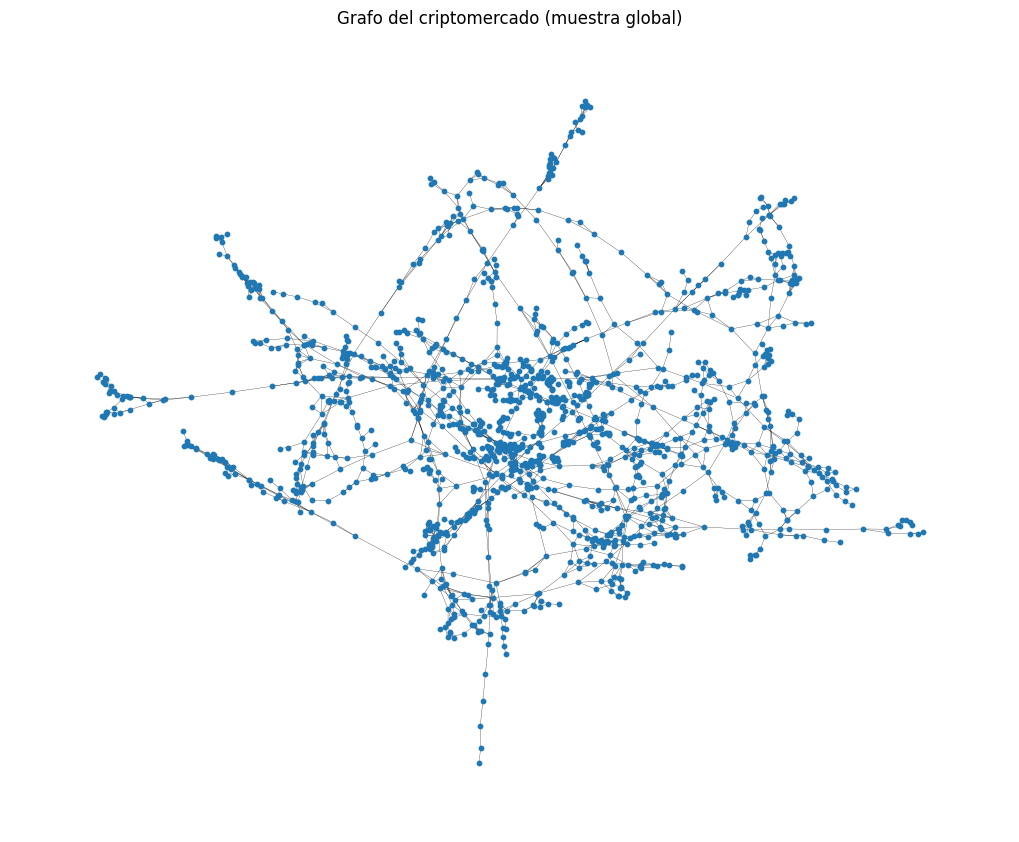

/tmp/ipython-input-1660700905.py:222: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


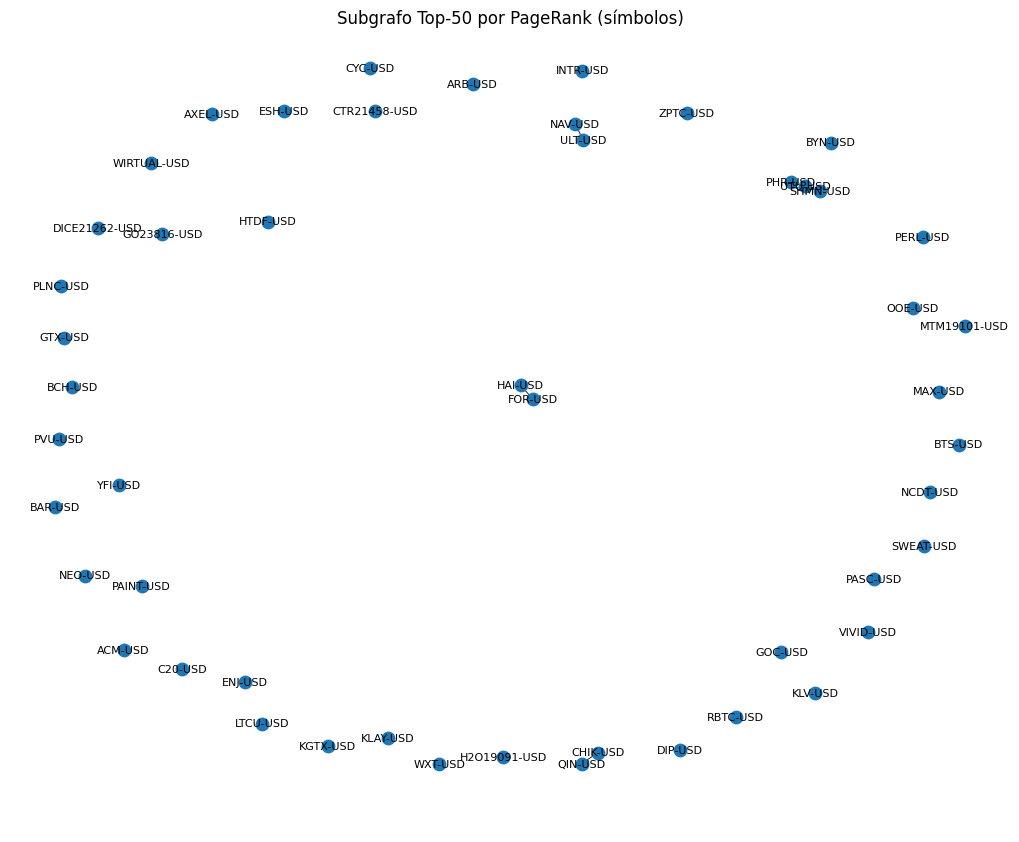

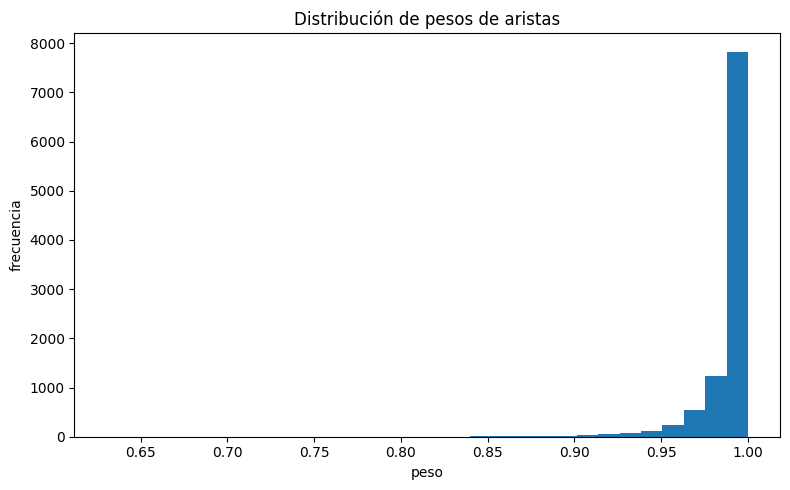

In [11]:
import os
import re
import math
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from datetime import datetime

CSV_PATH = "data.csv"
OUTPUT_DIR = "salidas_grafo"
K_NEIGHBORS = 5
SIMILARITY_METRIC = "cosine"
EDGE_WEIGHT = "similarity"
RANDOM_SEED = 42
PLOT_SAMPLE_NODES = 1500

COLS = {
    "symbol": "Symbol",
    "name": "Name",
    "price": "Price (Intraday)",
    "change_abs": "Change",
    "change_pct": "% Change",
    "market_cap": "Market Cap",
    "vol_since0": "Volume in Currency (Since 0:00 UTC)",
    "vol_24h": "Volume in Currency (24Hr)",
    "vol_24h_all": "Total Volume All Currencies (24Hr)",
    "circ_supply": "Circulating Supply",
}

SUFFIX_MAP = {"K": 1e3, "M": 1e6, "B": 1e9, "T": 1e12}

def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)

def parse_number(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)):
        return float(x)
    s = str(x).strip()
    if s in {"", "—", "-", "N/A", "NaN", "None"}:
        return np.nan
    s = s.replace(",", "")
    if s.endswith("%"):
        try:
            return float(s[:-1]) / 100.0
        except:
            return np.nan
    m = re.match(r"^([+-]?[0-9]*\.?[0-9]+)\s*([KMBT])$", s, re.IGNORECASE)
    if m:
        val = float(m.group(1))
        suf = m.group(2).upper()
        return val * SUFFIX_MAP.get(suf, 1.0)
    try:
        return float(s)
    except:
        return np.nan

def safe_div(a, b):
    out = a / b
    if isinstance(out, pd.Series):
        out = out.replace([np.inf, -np.inf], np.nan)
    return out

def safe_log1p(series):
    return np.log1p(series.clip(lower=0))

def main():
    assert os.path.isfile(CSV_PATH), f"No se encontró el archivo: {CSV_PATH}"
    df_raw = pd.read_csv(CSV_PATH)
    faltantes = [v for v in COLS.values() if v not in df_raw.columns]
    assert not faltantes, f"Faltan columnas en tu CSV: {faltantes}"

    df = pd.DataFrame({
        "symbol": df_raw[COLS["symbol"]],
        "name": df_raw[COLS["name"]],
        "price_usd": df_raw[COLS["price"]].apply(parse_number),
        "change_abs": df_raw[COLS["change_abs"]].apply(parse_number),
        "change_pct": df_raw[COLS["change_pct"]].apply(parse_number),
        "market_cap_usd": df_raw[COLS["market_cap"]].apply(parse_number),
        "volume_24h_usd": df_raw[COLS["vol_24h"]].apply(parse_number),
        "volume_since0_usd": df_raw[COLS["vol_since0"]].apply(parse_number),
        "total_volume_all_24h": df_raw[COLS["vol_24h_all"]].apply(parse_number),
        "circulating_supply": df_raw[COLS["circ_supply"]].apply(parse_number),
    })

    df = df.dropna(subset=["name", "symbol", "price_usd", "market_cap_usd"]).reset_index(drop=True)

    df["vol_ratio"] = safe_div(df["volume_24h_usd"], df["market_cap_usd"])
    df["price_usd_log"]   = safe_log1p(df["price_usd"])
    df["market_cap_log"]  = safe_log1p(df["market_cap_usd"])
    df["volume_24h_log"]  = safe_log1p(df["volume_24h_usd"])

    for c in ["vol_ratio","change_pct","circulating_supply","price_usd_log","market_cap_log","volume_24h_log"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        df[c] = df[c].replace([np.inf, -np.inf], np.nan)

    feature_cols = [
        "price_usd_log",
        "market_cap_log",
        "volume_24h_log",
        "vol_ratio",
        "change_pct",
        "circulating_supply",
    ]

    for c in feature_cols:
        if df[c].notna().sum() > 5:
            qlow, qhi = df[c].quantile(0.001), df[c].quantile(0.999)
            df[c] = df[c].clip(lower=qlow, upper=qhi)

    df = df.dropna(subset=feature_cols, how="all")
    X = df[feature_cols].fillna(0.0).astype(np.float64).values

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    if SIMILARITY_METRIC == "euclidean":
        mm = MinMaxScaler()
        X_model = mm.fit_transform(X_std)
        metric = "euclidean"
    else:
        X_model = X_std
        metric = "cosine"

    n = len(df)
    n_neighbors = min(K_NEIGHBORS + 1, n)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
    nbrs.fit(X_model)
    distances, indices = nbrs.kneighbors(X_model)

    def distance_to_weight(d):
        if SIMILARITY_METRIC == "cosine":
            sim = max(0.0, 1.0 - float(d))
            return sim if EDGE_WEIGHT == "similarity" else 1.0 / (1.0 + float(d))
        else:
            return (1.0 / (1.0 + float(d))) if EDGE_WEIGHT == "inv_distance" else (1.0 / (1.0 + float(d)))

    edges = {}
    for i in range(n):
        for jpos in range(1, n_neighbors):
            j = int(indices[i, jpos])
            if i == j:
                continue
            a, b = (i, j) if i < j else (j, i)
            d = float(distances[i, jpos])
            if (a, b) not in edges or d < edges[(a, b)]["distance"]:
                edges[(a, b)] = {
                    "distance": d,
                    "weight": distance_to_weight(d),
                }

    edges_df = pd.DataFrame(
        [(a, b, v["distance"], v["weight"]) for (a, b), v in edges.items()],
        columns=["source_id", "target_id", "distance", "weight"]
    )

    G = nx.Graph()
    for idx, row in df.iterrows():
        G.add_node(
            idx,
            symbol=row["symbol"],
            name=row["name"],
            price_usd=float(row["price_usd"]),
            market_cap_usd=float(row["market_cap_usd"]),
            volume_24h_usd=float(row["volume_24h_usd"]) if not math.isnan(row["volume_24h_usd"]) else 0.0,
            vol_ratio=float(row["vol_ratio"]) if not math.isnan(row["vol_ratio"]) else 0.0,
            change_pct=float(row["change_pct"]) if not math.isnan(row["change_pct"]) else 0.0,
            circulating_supply=float(row["circulating_supply"]) if not math.isnan(row["circulating_supply"]) else 0.0,
        )
    for _, r in edges_df.iterrows():
        G.add_edge(int(r["source_id"]), int(r["target_id"]), weight=float(r["weight"]), distance=float(r["distance"]))

    deg_cent = nx.degree_centrality(G)
    pagerank = nx.pagerank(G, alpha=0.85, weight="weight")

    ensure_dir(OUTPUT_DIR)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")

    nodos_out = df.copy()
    nodos_out["node_id"] = np.arange(len(df))
    nodos_out["degree_centrality"] = nodos_out["node_id"].map(deg_cent)
    nodos_out["pagerank"] = nodos_out["node_id"].map(pagerank)

    nodes_csv = os.path.join(OUTPUT_DIR, f"nodos_limpio_{ts}.csv")
    edges_csv = os.path.join(OUTPUT_DIR, f"aristas_{ts}.csv")
    nodos_out.to_csv(nodes_csv, index=False)
    edges_df.to_csv(edges_csv, index=False)

    print(f"[OK] Nodos: {G.number_of_nodes()}  | Aristas: {G.number_of_edges()}")
    print(f"[OK] Guardado: {nodes_csv}")
    print(f"[OK] Guardado: {edges_csv}")

    np.random.seed(RANDOM_SEED)

    if G.number_of_nodes() > PLOT_SAMPLE_NODES:
        sample_nodes = np.random.choice(list(G.nodes()), size=PLOT_SAMPLE_NODES, replace=False)
        H = G.subgraph(sample_nodes).copy()
    else:
        H = G.copy()

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(H, seed=RANDOM_SEED, weight="weight")
    nx.draw(H, pos, node_size=10, width=0.2, with_labels=False)
    plt.title("Grafo del criptomercado (muestra global)")
    plt.tight_layout()
    plt.show()

    top50 = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:50]
    H_top = G.subgraph([i for i,_ in top50]).copy()
    labels = {i: G.nodes[i]["symbol"] for i,_ in top50}

    plt.figure(figsize=(10, 8))
    pos_top = nx.spring_layout(H_top, seed=RANDOM_SEED, weight="weight")
    nx.draw(H_top, pos_top, node_size=80, width=0.6, with_labels=False)
    nx.draw_networkx_labels(H_top, pos_top, labels=labels, font_size=8)
    plt.title("Subgrafo Top-50 por PageRank (símbolos)")
    plt.tight_layout()
    plt.show()

    weights = [d["weight"] for _,_,d in G.edges(data=True)]
    plt.figure(figsize=(8, 5))
    plt.hist(weights, bins=30)
    plt.title("Distribución de pesos de aristas")
    plt.xlabel("peso")
    plt.ylabel("frecuencia")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
